# Weights & Biases와 함께 Pytorch Lightning 사용하기

https://wandb.ai/wandb_fc/korean/reports/Weights-Biases-Pytorch-Lightning---VmlldzozNzAxOTg  
위의 링크를 참고하여 작성하였습니다.

## Install dependencies

In [ ]:
!pip install -q wandb 
!pip install -q pytorch-lightning

## Import required modules

In [ ]:
# Weights & Biases
import wandb
from pytorch_lightning.loggers import WandbLogger

# Pytorch modules
import torch
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

# Pytorch-Lightning
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl

# Dataset
from torchvision.datasets import MNIST
from torchvision import transforms

In [ ]:
!pip install -q torchmetrics

In [ ]:
import torchmetrics

## Defining a model

In Pytorch-Lightning, models are built with `LightningModule`, equivalent to `torch.nn.Module` but with added functionality to simplify training.

Models are defined with:
* `__init__` for model parameters
* `forward` for inference
* `training_step` returns a loss from a single batch
* `configure_optimizers` defines the training optimizer

Additional methods can be defined such as:
* `validation_step` and `test_step` for logging metrics when working with validation & test data sets
* methods such as `training_step_end` and `training_epoch_end` for more complex loops
* other custom hooks for more flexibility

In [ ]:
class LitMNIST(LightningModule):

    def __init__(self, n_classes=10, n_layer_1=128, n_layer_2=256, lr=1e-3):
        '''method used to define our model parameters'''
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Linear(28 * 28, n_layer_1)
        self.layer_2 = torch.nn.Linear(n_layer_1, n_layer_2)
        self.layer_3 = torch.nn.Linear(n_layer_2, n_classes)

        # optimizer parameters
        self.lr = lr

        # metrics
        self.accuracy = torchmetrics.Accuracy()

        # optional - save hyper-parameters to self.hparams
        # they will also be automatically logged as config parameters in W&B
        self.save_hyperparameters()

    def forward(self, x):
        '''method used for inference input -> output'''

        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # Log training loss
        self.log('train_loss', loss)

        # Log metrics
        #self.log('train_acc', self.accuracy(logits, y))

        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # Log validation loss (will be automatically averaged over an epoch)
        self.log('valid_loss', loss)

        # Log metrics
        #self.log('valid_acc', self.accuracy(logits, y))

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # Log test loss
        self.log('test_loss', loss)

        # Log metrics
        #self.log('test_acc', self.accuracy(logits, y))
    
    def configure_optimizers(self):
        '''defines model optimizer'''
        return Adam(self.parameters(), lr=self.lr)

*Note: in this particular model we could refactor `training_step`, `validation_step` and `test_step` which share similar code.*

## Loading data

Data pipelines can be created with:
* Pytorch `DataLoaders`
* LightningModule `DataLoaders`
* `DataModules`

Using `DataModules` is recommended whenever possible as its structured definition allows for additional automated optimization such as workload distribution between CPU & GPU.

`DataModules` are defined with:
* `prepare_data` (optional) which is called only once and on 1 GPU
* `setup` which is called on each GPU separately and accepts `stage` to define if we are at `fit` or `test` step
* `train_dataloader`, `val_dataloader` and `test_dataloader` to load respectively training, validation and test datasets

In [ ]:
class MNISTDataModule(LightningDataModule):

    def __init__(self, data_dir='./', batch_size=256):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.ToTensor()

    def prepare_data(self):
        '''called only once and on 1 GPU'''
        # download data
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        '''called on each GPU separately - stage defines if we are at fit or test step'''
        # we set up only relevant datasets when stage is specified (automatically set by Pytorch-Lightning)
        if stage == 'fit' or stage is None:
            mnist_train = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        '''returns training dataloader'''
        mnist_train = DataLoader(self.mnist_train, batch_size=self.batch_size)
        return mnist_train

    def val_dataloader(self):
        '''returns validation dataloader'''
        mnist_val = DataLoader(self.mnist_val, batch_size=self.batch_size)
        return mnist_val

    def test_dataloader(self):
        '''returns test dataloader'''
        mnist_test = DataLoader(self.mnist_test, batch_size=self.batch_size)
        return mnist_test

## Setting up Weights & Biases

We log in to W&B (required only once per machine):
* in bash, `wandb login`
* in notebooks, `wandb.login`

In [ ]:
wandb.login()

Logging to W&B is automated by `WandbLogger`. Refer to [the documentation](https://docs.wandb.com/library/integrations/lightning) for custom options.



In [ ]:
wandb_logger = WandbLogger(project='MNIST')

## Training the model

We set up our data and model.

In [ ]:
# setup data
mnist = MNISTDataModule()
 
# setup model - choose different hyperparameters per experiment
model = LitMNIST(n_layer_1=128, n_layer_2=256, lr=1e-3)

We can then set up our trainer and customize several options, such as gradient accumulation, half precision training and distributed computing.

In [ ]:
trainer = Trainer(
    logger=wandb_logger,    # W&B integration
    gpus=-1,                # use all GPU's
    max_epochs=3            # number of epochs
    )

Training just requires a call to `fit` method.

In [ ]:
trainer.fit(model, mnist)

When a test set is available, we just need to call the `test` method.

In [ ]:
trainer.test(model, datamodule=mnist)

When we want to close our W&B run, we can call `wandb.finish()` (mainly useful in notebooks, called automatically in scripts).

In [ ]:
wandb.finish()

# 학습 결과

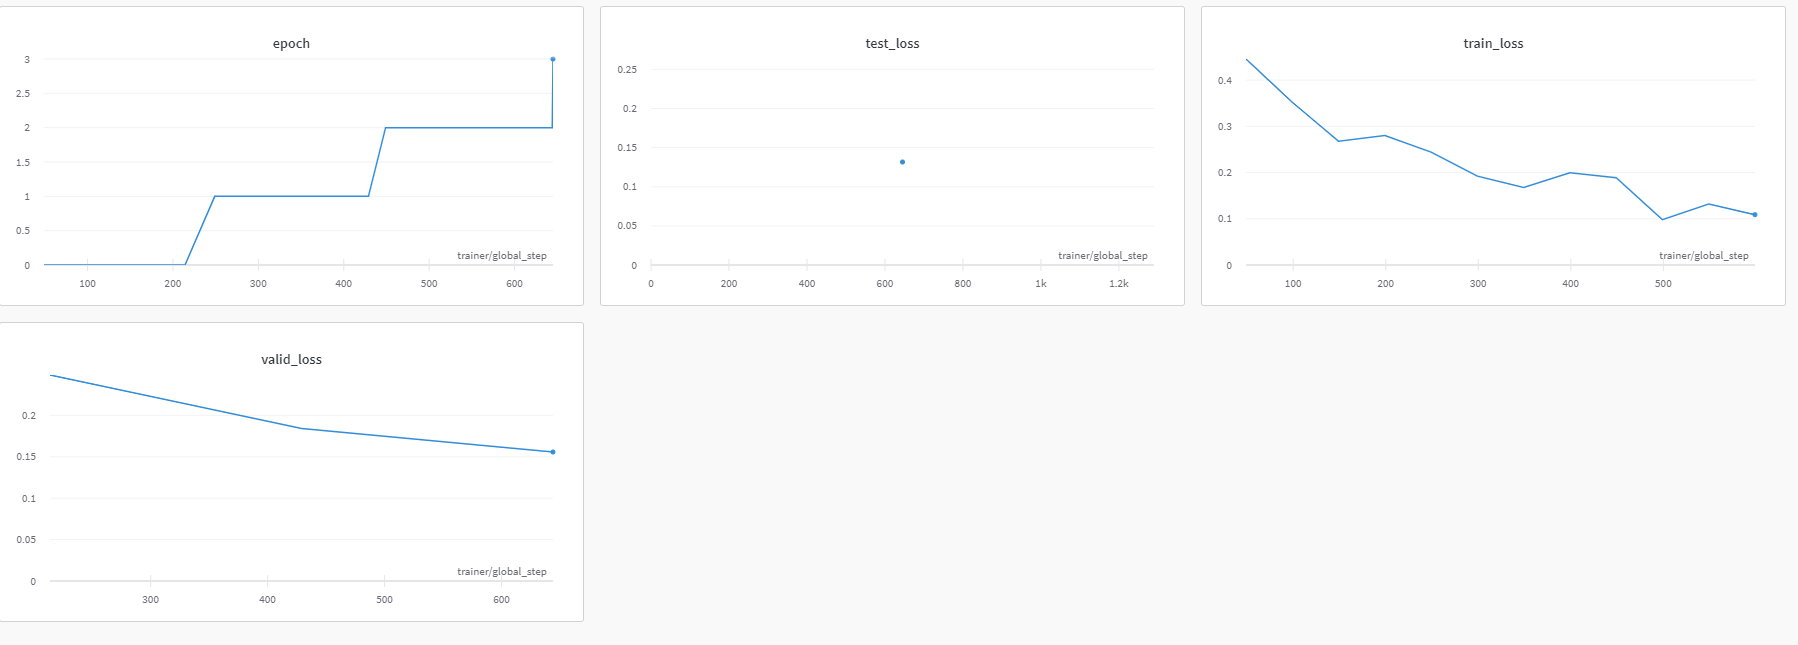